In [118]:
import pickle
import seaborn as sns
import os
from operator import lt, gt, eq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [76]:
def get_stats(directory):
    stats = []
    for timestamp in os.listdir(directory):
        file_path = '/'.join([directory, str(timestamp), 'stats.pkl'])
        with open(file_path, 'rb') as f:
            stats.append(pickle.load(f))
    
    return stats

def model_is_correct(w_true, w_model, threshold=0.1):
    return num_edges_correct(w_true, w_model, threshold) == legal_edges(len(w_true))

def num_edges_correct(w_true, w_model, threshold=0.1):
    # correct for 'illegal' edges because those are not learned and are always zero
    return ((w_model - w_true).abs().view(-1) < threshold).sum().item() - illegal_edges(len(w_true))

def total_edges(dim):
    return dim**2

def legal_edges(dim):
    return (dim - 1)**(2) / 2

def non_zero_edges(w_true):
    return (w_true != 0).sum().item()

def sparsity(w_true):
    return non_zero_edges(w_true) / legal_edges(len(w_true))

def illegal_edges(dim):
    return total_edges(dim) - legal_edges(dim)

def get_data(directory):
    stats = get_stats(directory)
    data = pd.DataFrame()
    
    for stat in stats:
        
        w_true = stat['true_weights']
        w_model = stat['model_weights']
        
        for i in range(len(stat['iterations'])):
            data = data.append({
                'dim' : int(w_true.shape[0]),
                'sparsity' : stat['config'].random_dag[1],
#                 'model_correct' : model_is_correct(w_true, w_model, threshold),
#                 'num_correct' : num_edges_correct(w_true, w_model, threshold),
#                 'total_edges' : total_edges(dim),
#                 'legal_edges' : legal_edges(dim),
#                 'percent_correct' : num_edges_correct(w_true, w_model, threshold) / legal_edges(dim),
                'model_name' : stat['config'].dag_name,
                'causal_err' : stat['causal_err'][i],
                'noise_err' : stat['noise_err'][i],
                'loss' : stat['loss']['pred'][i],
                'iterations' : stat['iterations'][i] + 1,
                'seed' : stat['config'].seed,
            }, ignore_index=True)
    
    data['dim'] = data['dim'].astype(int)
    return data

def relative_distance(A, B):
    assert A.size() == B.size(), 'Matrices should be equal shape'
    
    n,m = A.size()
    result = []
    for i in range(n):
        for j in range(m):
            if A[i,j].item() != 0:
                result.append((A[i,j] - B[i,j]).abs() / A[i,j].abs())
    
    return torch.tensor(result).max().item()

In [81]:
# data = get_data('../experiments/faulty_noise_err_progressive_size_two_step/')
# data = get_data('../experiments/no_noise_err_three_var_two_step//')
# data = get_data('../experiments/2493794/')
# data = get_data('../experiments/stacked_chain_two_step')
data = get_data('/Volumes/Lisa/causal_rl/experiments/2494061')

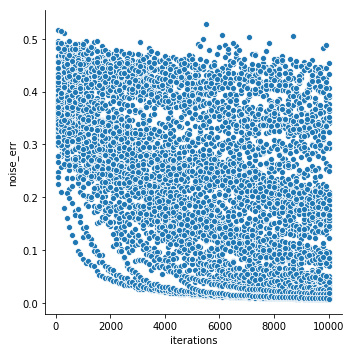

In [143]:
def filter_data(data, column, compare_func, value):
    return data[compare_func(data[column], value)]

data['split'] = data['sparsity'] > 0.5
sns.relplot(x='iterations', y='noise_err', data=data)

In [122]:
lt(data['iterations'], 100)

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
5970    False
5971    False
5972    False
5973    False
5974    False
5975    False
5976    False
5977    False
5978    False
5979    False
5980    False
5981    False
5982    False
5983    False
5984    False
5985    False
5986    False
5987    False
5988    False
5989    False
5990    False
5991    False
5992    False
5993    False
5994    False
5995    False
5996    False
5997    False
5998    False
5999    False
Name: iterations, Length: 6000, dtype: bool

AxesSubplot(0.125,0.125;0.775x0.755)
(20,) (20,)
tensor([[-0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000,  0.0000],
        [-0.9268,  0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         -0.0000, -0.0000],
        [ 0.0000,  0.6104,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
         -0.0000, -0.0000],
        [-1.0335, -0.0000,  0.2458,  0.3772,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, -0.0000],
        [-0.1179, -0.8294, -0.7722, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.9911,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000,
          0.0000, -0.0000],
        [ 0.0000, -0.3140, -1.0787,  0.2408, -1.3962,  0.0000, -0.3584, -0.0000,
         -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.7814,  0.0000, -1.7137, -0.0000, -0.4749, -0.6334

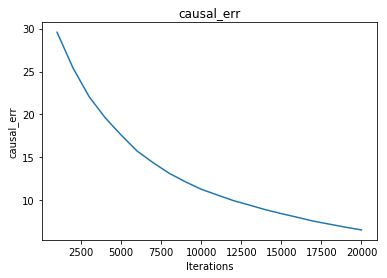

In [18]:
def plot_statistic_to_iterations(experiments):
    
    causal_errs = np.zeros((1, 50))
    fix, ax = plt.subplots(1,1)
    print(ax)
    for experiment in experiments:

        stats = get_stats('../{}/{}'.format('experiments', experiment))
                        
        causal_errs = [stat['causal_err'] for stat in stats]
        log_iters = np.tile(stats[0]['iterations'], len(causal_errs))
        causal_errs = np.array(causal_errs).reshape(1,-1).squeeze()

        print(causal_errs.shape, log_iters.shape)
#         sns.lineplot(x=log_iters, y=causal_errs, ax=ax)        

        for stat in stats:
            print(stat['true_weights'])
            print(stat['model_weights'])
            print(stat['causal_err'][-1])
            sns.lineplot(x=np.array(stat['iterations']), y=np.array(stat['causal_err']), ax=ax)

#     ax.legend(experiments)
    ax.set_title('causal_err')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('causal_err')
#     plt.ylim(bottom=0, top=1)
        
plot_statistic_to_iterations(['large_random_net'])

In [105]:
def plot_number_of_correct_models(path_to_experiment):

    data = pd.DataFrame()
    stats = get_stats(path_to_experiment)
    
    for i, stat in enumerate(stats):
        w_model = stat['model_weights']
        w_true = stat['true_weights']
        dim = len(w_true)
                        
        threshold = 0.2
        
#         print(model_is_correct(w_true, w_model, threshold))
#         print(w_model)
#         print(w_true)
#         print()
        data = data.append({
            'dim' : dim,
            'model_correct' : model_is_correct(w_true, w_model, threshold),
            'signs_correct' : signs_are_correct(w_true, w_model),
            'zeros_correct' : zeros_correct(w_true, w_model, threshold),
            'num_correct' : num_edges_correct(w_true, w_model, threshold),
            'total_edges' : total_edges(dim),
            'legal_edges' : legal_edges(dim),
            'percent_correct' : num_edges_correct(w_true, w_model, threshold) / legal_edges(dim),
            'model_name' : stat['config'].dag_name,
            'causal_err' : (w_true - w_model).abs().sum().item() / legal_edges(dim),
            'loss' : stat['loss']['pred'][-1],
            'seed' : stat['config'].seed,
        }, ignore_index=True)
    
#     g = sns.barplot(x='dim', y='legal_edges', data=data)
    g = sns.catplot(x='dim', y='noise_err', data=data)
    g.set_xticklabels(rotation=30, ha='right')

# plot_number_of_correct_models(os.path.join('../experiments/repeated_no_reg/'))
plot_number_of_correct_models(os.path.join('../experiments/2493794/'))

ValueError: Could not interpret input 'noise_err'

correct: 1
tensor([[ 0.0000, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000],
        [-0.1316, -0.7984,  0.0000]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1316, -0.7983,  0.0000]])
correct: 1
tensor([[-0.0000, -0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.8437,  0.9318,  0.0000]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0001,  0.0000,  0.0000],
        [-0.8436,  0.9319,  0.0000]])
correct: 1
tensor([[ 0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [-0.1468,  0.4851,  0.0000]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0001,  0.0000,  0.0000],
        [-0.1467,  0.4851,  0.0000]])
correct: 1
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 1.7528, -0.7396, -0.0000]])
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0001,  0.0000,  0.0000],
        [ 1.7528, -0.7396,  0.0000]])
correct: 1
tensor([[ 0.0000, -0.0000, -0.0000],
        [-0.

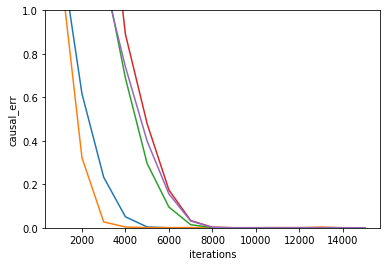

In [320]:

def plot_loss_to_optimal(path_to_experiment):
    
    stats = get_stats(path_to_experiment)    
#     fig, axes = plt.subplots(2,3, sharey=True)
    
    for idx, stat in enumerate(stats):
        data = pd.DataFrame()
        
        w_true = stat['true_weights']
        w_model = stat['model_weights']
        
        model_correct = model_is_correct(w_true, w_model, 0.15)
                        
        for i in range(len(stat['iterations'])):
            data = data.append({
                'seed' : int(stat['config'].seed),
                'loss' : stat['loss']['total'][i],
                'pred' : stat['loss']['pred'][i],
                'reg' : stat['loss']['reg'][i],
                'iterations' : stat['iterations'][i],
                'causal_err' : stat['causal_err'][i],
                'model_name' : stat['config'].dag_name
            }, ignore_index=True)
            
        i, j = divmod(idx, 3)
        
        if model_correct:
            plot_color = 'green'
        else:
            plot_color = 'red'
        
        print('correct:', model_correct)
        print(w_true)
        print(w_model)
#         print()
        
        plt.ylim(bottom=0, top=1)
        
#         axes[i,j].plot(data['iterations'], data['loss'], color=plot_color)
#         axes[i,j].plot(data['iterations'], data['ground'])
#         plt.plot(data['iterations'], data['pred'], color=plot_color, label='model')
#         plt.plot(data['iterations'], data['ground_pred'], label='true')
#         plt.plot(data['iterations'], data['causal_err'], label='causal_err', color=plot_color)
#         plt.ylabel('MSE')
#         plt.xlabel('iterations')
#         plt.legend()
        sns.lineplot(x='iterations', y='causal_err', data=data)
        
#         plt.figure()
        
plot_loss_to_optimal('../experiments/two_step_no_reg/')

5000
tensor(2956)
tensor(0.5912)
5000
tensor(2178)
tensor(0.4356)
5000
tensor(2064)
tensor(0.4128)
5000
tensor(2684)
tensor(0.5368)
5000
tensor(2275)
tensor(0.4550)


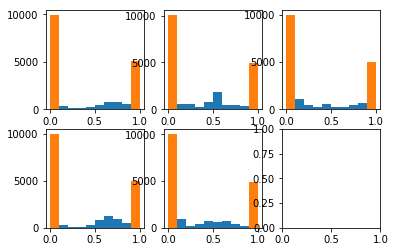

In [246]:
def histogram_of_loss(path_to_experiment):
    fix, axes = plt.subplots(2,3)
    stats = get_stats(path_to_experiment)
    for idx, stat in enumerate(stats):
        i,j = divmod(idx, 3)
        print(len(stat['loss']['pred'][10000:]))
        total_exact = ((torch.tensor(stat['loss']['pred'][10000:]) - 0).abs() < 0.05).sum()
        print(total_exact)
        print(total_exact.float() / len(stat['loss']['pred'][10000:]))
        axes[i,j].hist(stat['loss']['pred'], bins=10, range=(0,1))
        axes[i,j].hist(stat['ground_loss']['pred'], bins=10, range=(0,1))

histogram_of_loss('../experiments/identify_optimization_problem_granular/')

In [59]:
tips

,total_bill,tip,sex,smoker,day,time,size,dim
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,1
2,21.01,3.50,Male,No,Sun,Dinner,3,2
3,23.68,3.31,Male,No,Sun,Dinner,2,0
4,24.59,3.61,Female,No,Sun,Dinner,4,1
5,25.29,4.71,Male,No,Sun,Dinner,4,2
6,8.77,2.00,Male,No,Sun,Dinner,2,0
7,26.88,3.12,Male,No,Sun,Dinner,4,1
8,15.04,1.96,Male,No,Sun,Dinner,2,2
9,14.78,3.23,Male,No,Sun,Dinner,2,0


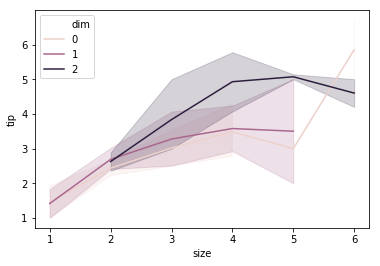

In [58]:
tips = sns.load_dataset('tips')
tips['dim'] = np.array([int(i*10 % 3) for i in range(len(tips))])
sns.lineplot(x='size', y='tip', hue='dim', data=tips)